In [199]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# import fields as f
# import fields_plot as fp
from pynvcenter import nv_optical_response as nv


import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

%matplotlib inline


%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define functions

### version 1 plotting contrast and frequencies

In [ ]:

def plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45):
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, 51)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_height = 80 # height of the dipole in um

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))

    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_contrast = nv.esr_contrast_ensemble(bfields)

    for c in np.array([contrast.flatten() for contrast in esr_contrast]).T:
        ax[0].plot(c,angle)

    #     for c in esr_contrast.T:
    # #         ax[0].plot(np.sum(bfields**2, axis=1))
    #         ax[0].plot(c)

    esr_freq = nv.esr_frequencies_ensemble(bfields)


    for f in np.array([freq.flatten() for freq in esr_freq]).T:
        ax[1].plot(f, angle)

    ax[0].set_xlabel('contrast')
    ax[0].set_ylabel('angle (deg)')
    ax[0].set_xlabel('freq (Hz)')
    ax[1].set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))

### version 2 plotting only frequencies

In [122]:

def plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45):
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, 101)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_height = 80 # height of the dipole in um

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])

    fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_freq = nv.esr_frequencies_ensemble(bfields)
    
    # sort freq such that lines are connected
#     esr_freq = nv.esr_connect(esr_freq)
    
    color = ['r', 'g', 'b', 'k']
    line = ['-', '--']
    for i, f in enumerate(np.array([freq.flatten() for freq in esr_freq]).T):
        ax.plot(f, angle, color[i // 2] + line[i % 2])

    ax.set_ylabel('angle (deg)')
    ax.set_xlabel('freq (Hz)')
    ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))

In [112]:
from pynvcenter.fields import b_field, b_field_single_dipole

In [113]:


particle_radius = 30 # particle radius in um

nv_radius = 70  # radius at which we measure the nvs

nv_x, nv_y = 5,0

theta_mag = 10 # theta angle of dipole orientation in degree
phi_mag = 45 # phi angle of dipole orientation in degree


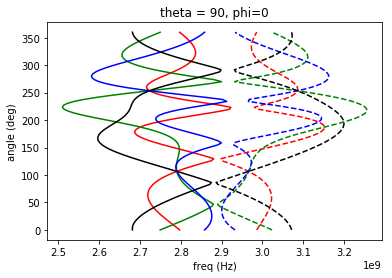

In [133]:
for x in [20]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y = x, theta_mag = 90, phi_mag = 0)

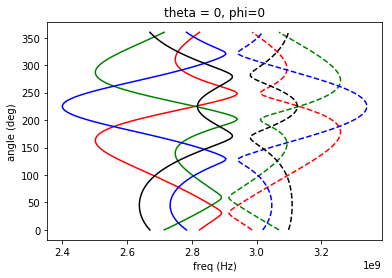

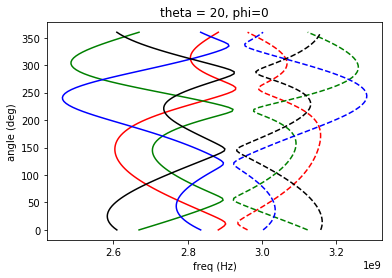

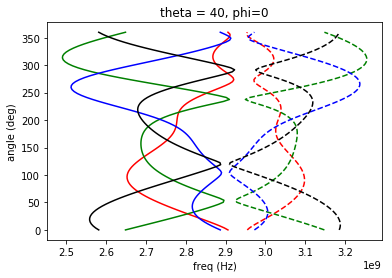

In [123]:
for t in [0, 20, 40]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=10, nv_y = 10, theta_mag = t, phi_mag = 0)

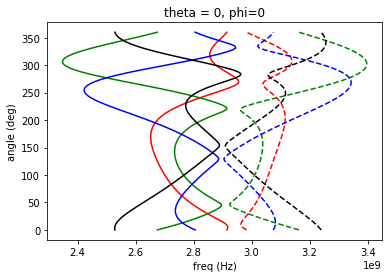

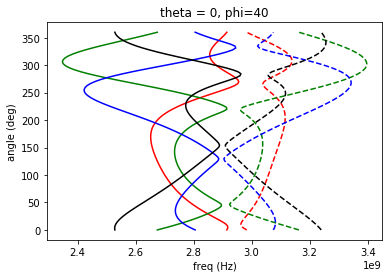

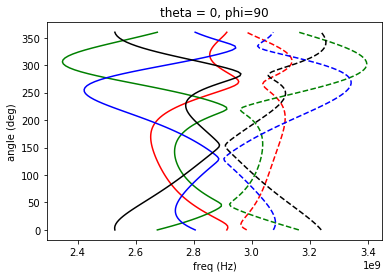

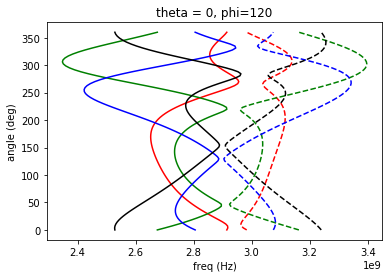

In [155]:
displacement = 20
angle = 115

angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for p in [0, 40, 90, 120]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y =y , theta_mag = 0, phi_mag = p)

### version 3 - a 2D map

In [224]:

def plot_esr_2D_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45, dipole_height = 80):
    """
         dipole_height = height of the dipole in um
    """
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, 51)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])

    fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_contrast = nv.esr_contrast_ensemble(bfields)

    esr_freq = nv.esr_frequencies_ensemble(bfields)
    
    signal = []
    for fo, contrast in zip(esr_freq, esr_contrast):
        signal.append(nv.esr_odmr_signal_ensemble(frequencies, fo.flatten(), contrast.flatten(), avrg_count_rate, linewidth=1e7))
    signal = np.array(signal)
    
    
    ax.pcolor(frequencies,angle, signal)
    
    ax.set_ylabel('angle (deg)')
    ax.set_xlabel('freq (Hz)')
    ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
    plt.tight_layout()

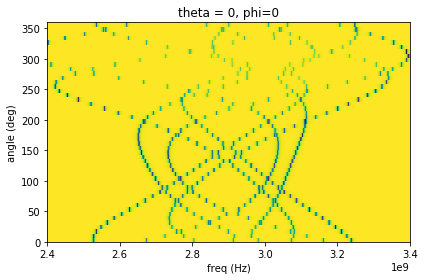

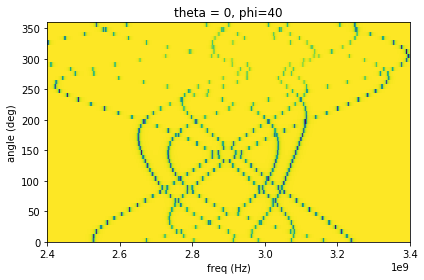

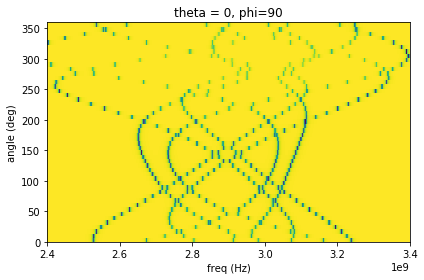

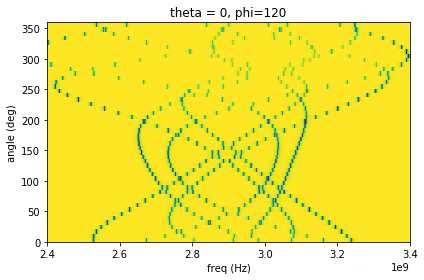

In [225]:
displacement = 20
angle = 115

angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for p in [0, 40, 90, 120]:

    plot_esr_2D_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y =y , theta_mag = 0, phi_mag = p)

In [192]:
displacement = 20
angle = 115

angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for p in [0, 40, 90, 120]:

    plot_esr_2D_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y =y , theta_mag = 0, phi_mag = p)

TypeError: object of type 'numpy.float64' has no len()

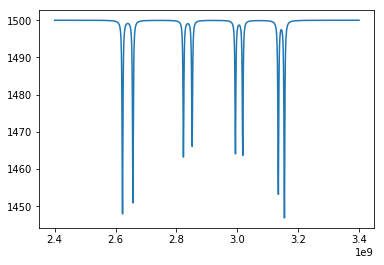

In [201]:

plt.plot(frequencies, signal)

In [182]:
contrast, co, c1

(14.524172089515192, 1500.0, 1500)

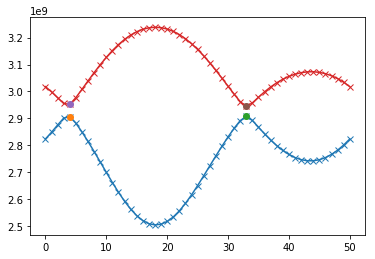

In [68]:



x = np.diff(esr_freq.reshape(esr_freq.shape[0],8)[:,0:2])[:,0]
# plt.plot(x, 'x-')

peaks, _ = find_peaks(1/x, distance=5)



    
for signal in esr_freq.reshape(esr_freq.shape[0],8)[:,0:2].T:
    plt.plot(signal, 'x-') 
    for p in peaks:
        plt.plot(p, signal[p], 'o')

In [69]:
a, b = esr_freq.reshape(esr_freq.shape[0],8)[:,0:2].T

In [72]:
p1, p2  = peaks

In [74]:
a, b = np.hstack([a[0:p1], b[p1:p2], a[p2:]]), np.hstack([b[0:p1], a[p1:p2], b[p2:]])

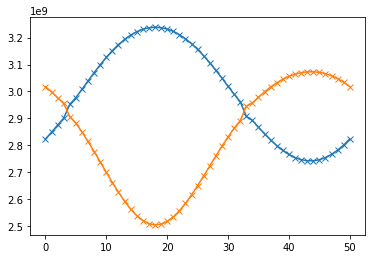

In [76]:
plt.plot(a, '-x')
plt.plot(b, '-x')

In [54]:
x.shape

(51, 1)